<a href="https://colab.research.google.com/github/karino2/tegashiki/blob/master/tegashiki_vec_tputrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tegashiki

In [0]:
import os
import datetime
import pickle
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import preprocessing

In [2]:
tf.VERSION

'1.14.0'

In [3]:
from google.colab import auth
auth.authenticate_user()

W0901 06:42:18.214214 139821955409792 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
BEGIN_OF_SEQ = 113
END_OF_SEQ=112
PAD_TOKEN=0
VOCAB_SIZE=122


# Both train and valid
MAX_ONE_STROKE_LEN=50
# MAX_STROKE_NUM=22
MAX_STROKE_NUM=27

# MAX_TEX_LEN=206+2
# +2 is bos, eos
# +2 is bos, eos
# MAX_TOKEN_LEN=88+2
# MAX_TRAIN_LEN=88+2
# MAX_TOKEN_LEN=3+2
# MAX_TOKEN_LEN=10+2
MAX_TOKEN_LEN=14+2



NORMALIZE_MAX=2000

# must match to trained dim
EXTRACTED_FEATURE_DIM=256
FE_DROPOUT_RATE=0.5
FE_L2_REGULARIZATION_RATE=0.01

INPUT_TYPE_POINT=1
INPUT_TYPE_END=0

# (x, y, TYPE)
INPUT_TYPE_DIM=3

## Model

In [0]:
import tensorflow as tf

from tensorflow.keras.layers import Input, GRU, Dense, RepeatVector, Reshape, Concatenate
from tensorflow.keras.layers import TimeDistributed, Flatten, Lambda, Add, Activation, Masking, Embedding
from tensorflow.keras.layers import AveragePooling1D, Conv1D, MaxPooling1D, SpatialDropout1D
from tensorflow.keras.layers import Dropout, GlobalMaxPooling1D
from tensorflow.keras import regularizers
import  tensorflow.keras.layers as layers
# from tensorflow.keras.layers.embeddings import Embedding
import tensorflow.keras.backend as K

In [0]:
#DROPOUT_RATE=0.9
DROPOUT_RATE=0.5 # obsolete
ENCODER_DROPOUT_RATE=0.1
DECODER_DROPOUT_RATE=0.1
L2_REGULARIZATION_RATE=1e-6

FEATURE_EXTRACTER_KERNEL_SIZE=7

# FILTER_SIZE=3
# KERNEL_SIZE=8

FILTER_NUM=128
# KERNEL_SIZE=5
DECODER_KERNEL_SIZE=12
ENCODER_KERNEL_SIZE=5
# 5x 5layer = 25 > max_stroke_num

# large

# EMBEDDING_SIZE=256
# OT_HIDDEN=256
# GRU_HIDDEN=256
# ATTENTION_ENC_HIDDEN=256
# ATTENTION_DEC_HIDDEN=256

# model_small
EMBEDDING_SIZE=32
OT_HIDDEN=128
GRU_HIDDEN=128
ATTENTION_ENC_HIDDEN=64
ATTENTION_DEC_HIDDEN=64

# model_small_embed acc 0.22
# EMBEDDING_SIZE=32

# OT_HIDDEN=256
# GRU_HIDDEN=256
# ATTENTION_ENC_HIDDEN=256
# ATTENTION_DEC_HIDDEN=256



In [0]:
def fe_conv1d(filternum, kernelsize, x):
    return tf.layers.Conv1D(filternum, kernelsize, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(x)
  

def feature_extractor(input_stroke_t, is_training):
  """input_stroke_t shape (batch, MAX_STROKE_NUM, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM)"""
  with tf.variable_scope("feature_extractor"):
    inpshape = input_stroke_t.shape
    x = tf.reshape(input_stroke_t, [-1, inpshape[2], inpshape[3]])
    # (batch*MAX_STROKE_NUM, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM)

    x = fe_conv1d(32, FEATURE_EXTRACTER_KERNEL_SIZE, x)
    x = tf.layers.BatchNormalization()(x, training=is_training)
    x = Activation('relu')(x)
    # (batch*MAX_STROKE_NUM, MAX_ONE_STROKE_LEN, 32)
    x = tf.layers.MaxPooling1D(pool_size=2, strides=2)(x)
    x = tf.layers.Dropout(FE_DROPOUT_RATE)(x, training=is_training)
    # (batch*MAX_STROKE_NUM, MAX_ONE_STROKE_LEN/2, 32)

    x = fe_conv1d(64, FEATURE_EXTRACTER_KERNEL_SIZE, x)
    x = tf.layers.BatchNormalization()(x, training=is_training)
    x = Activation('relu')(x)
    x = tf.layers.MaxPooling1D(pool_size=2, strides=2)(x)
    x = tf.layers.Dropout(FE_DROPOUT_RATE)(x, training=is_training)
    # (batch*MAX_STROKE_NUM, MAX_ONE_STROKE_LEN/4, 64)

    x = fe_conv1d(EXTRACTED_FEATURE_DIM, FEATURE_EXTRACTER_KERNEL_SIZE, x)
    x = tf.layers.BatchNormalization()(x, training=is_training)
    x = Activation('relu')(x)
    x = tf.layers.Dropout(FE_DROPOUT_RATE)(x, training=is_training)
    x = GlobalMaxPooling1D()(x)
    x = tf.reshape(x, [-1, inpshape[1], EXTRACTED_FEATURE_DIM])
    return x
  
def attention_context(ht_enc, ht_dec, maxtklen):
  w1 = tf.layers.Dense(ATTENTION_ENC_HIDDEN, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(ht_enc)
  w2 = tf.layers.Dense(ATTENTION_DEC_HIDDEN, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(ht_dec)
                       
  # w1 (sample, 276, 256)
  # w2 (samples, 90, 256)


  w2_widen = tf.expand_dims(w2, axis=1)
  # (sample, 1, 90, 256)

  w1_widen = tf.expand_dims(w1, axis=2)
  # (sample, 276, 1, 256)

  w1_widen_repeat = K.repeat_elements(w1_widen, rep=maxtklen, axis=2)
  # (sample, 276, 90, 256)
  
  score =tf.nn.tanh(w1_widen_repeat+w2_widen)
  prob = tf.layers.Dense(1, activation="softmax", kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(score)
  # score: (sample, 276, 90, 256)
  # prob: (sample, 276, 90, 1)

  ht_enc_repeated = K.repeat_elements(tf.expand_dims(ht_enc, axis=2), rep=maxtklen, axis=2)
  # (sample, 276, 90, 256)

  context_vec = tf.reduce_sum(prob*ht_enc_repeated, axis=1)
  # (sample, 90, 256)

  return context_vec  

In [0]:
TRANSFORMER_H = 8
TRANSFORMER_D=64
TRANSFORMER_D_MODEL=TRANSFORMER_H*TRANSFORMER_D


In [0]:
def layer_norm(x):
  """Layer norm only for last dimension."""
  return tf.contrib.layers.layer_norm(inputs=x, begin_norm_axis=-1, begin_params_axis=-1)

In [0]:

# same as tensorflow official implementation, but specify each dim for XLA
# https://github.com/tensorflow/models/blob/master/official/transformer/model/attention_layer.py
def split_heads(x, seqlen, num_heads=TRANSFORMER_H, one_depth=TRANSFORMER_D):
  x = tf.reshape(x, [-1, seqlen, num_heads, one_depth])
  return tf.transpose(x, [0, 2, 1, 3])  

def multihead_attention(query, query_seq_len, y, y_seq_len, mask_bias, dropout_rate, is_training):
  num_head = TRANSFORMER_H
  size_per_head = TRANSFORMER_D
  multi_q = tf.layers.Dense(num_head*size_per_head, use_bias=False)(query)
  multi_k = tf.layers.Dense(num_head*size_per_head, use_bias=False)(y)
  multi_v = tf.layers.Dense(num_head*size_per_head, use_bias=False)(y)
  k_seq_len = v_seq_len = y_seq_len
  
  multi_q = split_heads(multi_q, query_seq_len)
  multi_k = split_heads(multi_k, k_seq_len)
  multi_v = split_heads(multi_v, v_seq_len)
  
  multi_q *= TRANSFORMER_D ** -0.5

  # Calculate dot product attention
  logits = tf.matmul(multi_q, multi_k, transpose_b=True)
  
  logits += mask_bias
  
  weights = tf.nn.softmax(logits)
  weights = tf.layers.Dropout(dropout_rate)(weights, training=is_training)
  attention_output = tf.matmul(weights, multi_v)

  # Recombine heads --> [batch_size, num_head, query_seq_len, size_per_head]
  attention_output = tf.transpose(attention_output, [0, 2, 1, 3]) # --> [batch, query_seq_len, num_heads, size_per_head]
  attention_output = tf.reshape(attention_output, [-1, query_seq_len, TRANSFORMER_D_MODEL])
  
  attention_output = tf.layers.Dense(TRANSFORMER_D_MODEL, use_bias=False)(attention_output)
  # [64, 22, 512]
  
  return attention_output  



### Encoder

In [0]:
"""
def myembedding(input, num_classes, embedding_size, name):
  randinitializer = lambda: tf.random_uniform([num_classes, embedding_size], -1.0, 1.0)
  embedmat = tf.get_variable(name, initializer = randinitializer)
  return tf.nn.embedding_lookup(embedmat, input)  
"""

# dynamic shape cause TPUEstimator export to fail...
def myembedding(input, num_classes, embedding_size, seq_num, name):
  with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    randinitializer = lambda: tf.random_uniform([num_classes, embedding_size], -0.05, 0.05)

    embedmat = tf.get_variable(name, initializer = randinitializer)
    # embedding_lookup with generated tensor (eg. tf.range) cause TFLite convert fail.
    # return tf.nn.embedding_lookup(embedmat, input)
    onehot = tf.one_hot(input, num_classes)
    # batch_num, seqnum = onehot.shape[0], onehot.shape[1]    
    # flatten_onehot = tf.reshape(onehot, [batch_num*seq_num, num_classes])
    flatten_onehot = tf.reshape(onehot, [-1, num_classes])
    return tf.reshape(tf.matmul(flatten_onehot, embedmat), [-1, seq_num, embedding_size])

def embed_stroke(stroke_features):
  pos_stroke = tf.range(
            0,
            tf.shape(stroke_features)[1],
            delta=1,
            dtype=tf.int32,
            name='range')
  # pos_stroke = tf.expand_dims(tf.expand_dims(pos_stroke, axis=1), axis=0)
  pos_stroke = tf.expand_dims(pos_stroke, axis=0)
  pos_stroke_embed = myembedding(pos_stroke, MAX_STROKE_NUM, EXTRACTED_FEATURE_DIM, MAX_STROKE_NUM, "stroke_pos_embed")
  # pos_stroke_embed = Embedding(MAX_STROKE_NUM, EXTRACTED_FEATURE_DIM, input_length=MAX_STROKE_NUM)(pos_stroke)
  
  stroke_pos_embedded = stroke_features + tf.cast(x=pos_stroke_embed, dtype=stroke_features.dtype)
  return stroke_pos_embedded

In [0]:
def encConv1D(filternum, kernelsize, input):
  return tf.layers.Conv1D(filternum, kernelsize, activation='relu', padding='same', kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(input)

def encSelfAttenBlock_SingleHead(input, is_training):
  context_vec = attention_context(input, input, MAX_STROKE_NUM)
  
  attenres = tf.contrib.layers.layer_norm(input+context_vec)
  x = encConv1D(2048, 1, attenres)
  x = encConv1D(512, 1, x)
  x = SpatialDropout1D(ENCODER_DROPOUT_RATE)(x, training=is_training)
  return tf.contrib.layers.layer_norm(attenres+x)

def encOneBlock(filternum, kernelsize, dropout_rate, is_training, input):
  x = encConv1D(filternum, kernelsize, input)
  x = tf.contrib.layers.layer_norm(x)
  return SpatialDropout1D(dropout_rate)(x, training=is_training)

def encoder_CNN(stroke_enc, is_training, dropout_rate=DROPOUT_RATE):
  x = encOneBlock(EXTRACTED_FEATURE_DIM*4, ENCODER_KERNEL_SIZE, dropout_rate, is_training, stroke_enc)
  x = encOneBlock(EXTRACTED_FEATURE_DIM*4, ENCODER_KERNEL_SIZE, dropout_rate, is_training, x)
  x = encOneBlock(EXTRACTED_FEATURE_DIM*4, ENCODER_KERNEL_SIZE, dropout_rate, is_training, x)
  x = encOneBlock(EXTRACTED_FEATURE_DIM*4, ENCODER_KERNEL_SIZE, dropout_rate, is_training, x)
  x = encOneBlock(EXTRACTED_FEATURE_DIM*4, ENCODER_KERNEL_SIZE, dropout_rate, is_training, x)
  return x

def encoder_FC(stroke_enc):
  return tf.layers.Dense(EXTRACTED_FEATURE_DIM, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(stroke_enc)
  

Transformer

In [0]:
def mask_to_maskbias(mask):
  # unmasked element to by -infinity.
  mask = tf.cast(mask, tf.float32)
  mask_bias = (-1e9)*(1.-mask)
  mask_bias = tf.expand_dims(tf.expand_dims(mask_bias, axis=1), axis=1)
  # [batch, 1, 1, length]
  return mask_bias



def encSelfAttenOneBlock(input, mask_bias, is_training):
  # input - [64,22,512]
  attention_output =  multihead_attention(input, MAX_STROKE_NUM, input, MAX_STROKE_NUM, mask_bias, ENCODER_DROPOUT_RATE, is_training)
  attention_output = SpatialDropout1D(ENCODER_DROPOUT_RATE)(attention_output, training=is_training)
  attention_output = layer_norm(attention_output + input)
  
  intermediate_output = tf.layers.Dense(2048,activation='relu', use_bias=False)(attention_output)
  layer_output = tf.layers.Dense(TRANSFORMER_D_MODEL,use_bias=False)(intermediate_output)
  layer_output = SpatialDropout1D(ENCODER_DROPOUT_RATE)(layer_output, training=is_training)
  return layer_norm(layer_output+attention_output)

def encoder_SelfAttention(input, mask_bias, is_training):
  x = tf.layers.Dense(TRANSFORMER_D_MODEL,use_bias=False)(input)
  x = SpatialDropout1D(ENCODER_DROPOUT_RATE)(x, training=is_training)
  x = encSelfAttenOneBlock(x, mask_bias, is_training)
  x = encSelfAttenOneBlock(x, mask_bias, is_training)
  x = encSelfAttenOneBlock(x, mask_bias, is_training)
  x = encSelfAttenOneBlock(x, mask_bias, is_training)
  x = encSelfAttenOneBlock(x, mask_bias, is_training)
  x = encSelfAttenOneBlock(x, mask_bias, is_training)
  return x


### Decoder

In [0]:
def embed_decoder(decoder_input_t):
   # dec_input_embedded = Embedding(VOCAB_SIZE, EMBEDDING_SIZE, input_length=decoder_input_t.shape[1])(decoder_input_t)
  dec_input_embedded = myembedding(decoder_input_t, VOCAB_SIZE, EMBEDDING_SIZE, MAX_TOKEN_LEN, "dec_embed")
  # (batch, 98, 256)
  
  dec_pos_input = tf.range(
            0,
            tf.shape(decoder_input_t)[1],
            delta=1,
            dtype=tf.int32,
            name='range')
  
  # [5] -> [1, 5, 1]
  # dec_pos_input = tf.expand_dims(tf.expand_dims(dec_pos_input, axis=1), axis=0)
  # [5] -> [1, 5]
  dec_pos_input = tf.expand_dims(dec_pos_input, axis=0)
  # dec_pos_embed = Embedding(MAX_TOKEN_LEN, EMBEDDING_SIZE, input_length=MAX_TOKEN_LEN)(dec_pos_input)
  dec_pos_embed = myembedding(dec_pos_input, MAX_TOKEN_LEN, EMBEDDING_SIZE, MAX_TOKEN_LEN, "dec_pos_embed")
  
  
  dec_embedded = dec_input_embedded + tf.cast(x=dec_pos_embed, dtype=dec_input_embedded.dtype)
  # [32,5,32], [1,5,1,32].
  return dec_embedded

Transformer

In [0]:
# dynamic shape cause TPUEstimator export to fail...
# For transformer decoder, use the same weight for embedding and reverse-embedding
class SharedEmbedder:
  def __init__(self, num_classes, embeding_size=TRANSFORMER_D_MODEL,seq_num=MAX_TOKEN_LEN, name="dec_embed"):
    self.num_classes = num_classes
    self.embedding_size = embeding_size
    self.seq_num = seq_num
    
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
      randinitializer = lambda: tf.random_uniform([num_classes, embeding_size], -0.05, 0.05)

      self.embedmat = tf.get_variable(name, initializer = randinitializer)
  def embed(self, input):
    # embedding_lookup with generated tensor (eg. tf.range) cause TFLite convert fail.
    # return tf.nn.embedding_lookup(embedmat, input)
    onehot = tf.one_hot(input, self.num_classes)
    # batch_num, seqnum = onehot.shape[0], onehot.shape[1]    
    # flatten_onehot = tf.reshape(onehot, [batch_num*seq_num, num_classes])
    flatten_onehot = tf.reshape(onehot, [-1, self.num_classes])
    return tf.reshape(tf.matmul(flatten_onehot, self.embedmat), [-1, self.seq_num, self.embedding_size])
  def reverse_embed(self,x):
    x = tf.reshape(x, [-1, self.embedding_size])
    logits = tf.matmul(x, self.embedmat, transpose_b=True)

    return tf.reshape(logits, [-1, self.seq_num, self.num_classes])    



In [0]:
def embed_decoder_trans(decoder_input_t):
  embedder = SharedEmbedder(VOCAB_SIZE, TRANSFORMER_D_MODEL, MAX_TOKEN_LEN, "dec_embed")
  dec_input_embedded = embedder.embed(decoder_input_t)
  
  dec_pos_input = tf.range(
            0,
            tf.shape(decoder_input_t)[1],
            delta=1,
            dtype=tf.int32,
            name='range')
  
  # [5] -> [1, 5, 1]
  # dec_pos_input = tf.expand_dims(tf.expand_dims(dec_pos_input, axis=1), axis=0)
  # [5] -> [1, 5]
  dec_pos_input = tf.expand_dims(dec_pos_input, axis=0)
  # dec_pos_embed = Embedding(MAX_TOKEN_LEN, EMBEDDING_SIZE, input_length=MAX_TOKEN_LEN)(dec_pos_input)
  dec_pos_embed = myembedding(dec_pos_input, MAX_TOKEN_LEN, TRANSFORMER_D_MODEL, MAX_TOKEN_LEN, "dec_pos_embed")
  
  
  dec_embedded = dec_input_embedded + tf.cast(x=dec_pos_embed, dtype=dec_input_embedded.dtype)
  # [32,5,32], [1,5,1,32].
  return dec_embedded, embedder

In [0]:
# mask for decoder
def subsequent_mask_bias(size):
  mask = tf.linalg.band_part(tf.ones([size, size], dtype=tf.float32),-1, 0)
  mask = tf.reshape(mask, [1, 1, size, size])
  mask_bias = (-1e9)*(1.-mask)  
  return mask_bias


In [0]:

def decoderTransOneBlock(decoder_inputs, decoder_mask_bias, ht_enc, stroke_mask_bias, is_training):
  ht_dec =  multihead_attention(decoder_inputs, MAX_TOKEN_LEN, decoder_inputs, MAX_TOKEN_LEN, decoder_mask_bias, DECODER_DROPOUT_RATE, is_training)
  ht_dec = SpatialDropout1D(DECODER_DROPOUT_RATE)(ht_dec, training=is_training)
  ht_dec = layer_norm(ht_dec + decoder_inputs)
    
  attention_output =  multihead_attention(ht_dec, MAX_TOKEN_LEN, ht_enc, MAX_STROKE_NUM, stroke_mask_bias, DECODER_DROPOUT_RATE, is_training)
  attention_output = SpatialDropout1D(DECODER_DROPOUT_RATE)(attention_output, training=is_training)
  attention_output = layer_norm(attention_output + ht_dec)
  
  intermediate_output = tf.layers.Dense(2048,activation='relu', use_bias=False)(attention_output)
  layer_output = tf.layers.Dense(TRANSFORMER_D_MODEL,use_bias=False)(intermediate_output)
  layer_output = SpatialDropout1D(DECODER_DROPOUT_RATE)(layer_output, training=is_training)
  return layer_norm(layer_output+attention_output)


In [0]:
def decoder_Transformer(dec_input, ht_enc, stroke_mask_bias, is_training):
  dec_mask_bias = subsequent_mask_bias(MAX_TOKEN_LEN)
  
  # Shift targets to the right, and remove the last element
  # dec_input = tf.pad(dec_input, [[0, 0], [1, 0], [0, 0]])[:, :-1, :]  
    
  ht_dec = SpatialDropout1D(DECODER_DROPOUT_RATE)(dec_input, training=is_training)
  # ht_dec = tf.layers.Dense(TRANSFORMER_D_MODEL,use_bias=False)(dec_input)
  
  ht_dec = decoderTransOneBlock(ht_dec, dec_mask_bias, ht_enc, stroke_mask_bias, is_training)
  ht_dec = decoderTransOneBlock(ht_dec, dec_mask_bias, ht_enc, stroke_mask_bias, is_training)
  ht_dec = decoderTransOneBlock(ht_dec, dec_mask_bias, ht_enc, stroke_mask_bias, is_training)
  ht_dec = decoderTransOneBlock(ht_dec, dec_mask_bias, ht_enc, stroke_mask_bias, is_training)
  ht_dec = decoderTransOneBlock(ht_dec, dec_mask_bias, ht_enc, stroke_mask_bias, is_training)
  ht_dec = decoderTransOneBlock(ht_dec, dec_mask_bias, ht_enc, stroke_mask_bias, is_training)
  ht_dec = decoderTransOneBlock(ht_dec, dec_mask_bias, ht_enc, stroke_mask_bias, is_training)
  return ht_dec

In [0]:
def decoder_CNN(dec_embedded, is_training):
  x = tf.layers.Conv1D(FILTER_NUM, DECODER_KERNEL_SIZE, activation='relu', padding='causal', kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(dec_embedded)
  # This will cause future information leak!
  # x = tf.contrib.layers.layer_norm(x)
  return SpatialDropout1D(DROPOUT_RATE)(x, training=is_training)

def decoder_CnnWithAttentionBlock(dec_input, ht_enc, is_training):
  x = tf.layers.Conv1D(FILTER_NUM, DECODER_KERNEL_SIZE, activation='relu', padding='causal', kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(dec_input)
  # This will cause future information leak!
  # x = tf.contrib.layers.layer_norm(x)
  ht_dec = SpatialDropout1D(DROPOUT_RATE)(x, training=is_training)
  
  context_vec = attention_context(ht_enc, ht_dec, MAX_TOKEN_LEN)
  
  ht_with_cont = Concatenate()([ht_dec, context_vec])
  pw_conved = tf.layers.Conv1D(EXTRACTED_FEATURE_DIM, 1, activation='relu', padding='causal', kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(ht_with_cont)
  
  return SpatialDropout1D(DROPOUT_RATE)(pw_conved, training=is_training)



### create_model

In [0]:
def create_model(input_stroke_t, stroke_mask, decoder_input_t, is_training):
  stroke_features = feature_extractor(input_stroke_t, is_training)
  # (batch, MAX_STROKE_NUM, EXTRACTED_FEATURE_DIM)
  
  stroke_embedded = embed_stroke(stroke_features)
  dec_embedded, embedder = embed_decoder_trans(decoder_input_t)
  

  # ht_enc = stroke_pos_embedded
  # ht_enc = encoder_CNN(stroke_embedded, is_training)
  stroke_mask_bias = mask_to_maskbias(stroke_mask)
  ht_enc = encoder_SelfAttention(stroke_embedded, stroke_mask_bias, is_training)
  # ht_enc = encoder_FC(stroke_pos_embedded)
 
  # dec_ht = decoder_CnnWithAttentionBlock(dec_embedded, ht_enc, is_training)
  dec_ht = decoder_Transformer(dec_embedded, ht_enc, stroke_mask_bias, is_training)
  
  logit = embedder.reverse_embed(dec_ht)

  # (batch, MAX_TOKEN_LEN, 256)
  # ot = tf.layers.Dense(OT_HIDDEN, activation="tanh", kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(dec_ht)

  # (batch, MAX_TOKEN_LEN, VOCAB_SIZE
  # logit = TimeDistributed(tf.layers.Dense(VOCAB_SIZE, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE)))(ot)

  return logit

In [0]:
def sparse_softmax_cross_entropy_with_mask(sparse_labels, logit, mask):
  mask = tf.cast(mask, tf.float32)
  mask_expands = tf.expand_dims(mask, axis=2)
  return tf.losses.sparse_softmax_cross_entropy(sparse_labels, logit, mask_expands)

## TPUEstimator

In [0]:
DATA_DIR="gs://karino2-tegashiki/dataset"
TF_RECORD_FILE="{}/crohme2019_pat3_train.tfrecord.gz".format(DATA_DIR)
TF_VALID_RECORD_FILE="{}/crohme2019_pat3_valid.tfrecord.gz".format(DATA_DIR)
FEATURE_EXTRACTOR_DIR="gs://karino2-tegashiki/sym_models/fe_layersbatchnorm"

In [0]:

# MODEL_DIR="gs://karino2-tegashiki/models/plain_encdecatten_pat2"
# MODEL_DIR="gs://karino2-tegashiki/models/plain_encdecatten_pat2_trainopfix"

# MODEL_DIR="gs://karino2-tegashiki/models/encselfattn_pat2"
# MODEL_DIR="gs://karino2-tegashiki/models/encself_dropout01"
# MODEL_DIR="gs://karino2-tegashiki/models/encself_fixatten"
# MODEL_DIR="gs://karino2-tegashiki/models/encself_dropout05"

# MODEL_DIR="gs://karino2-tegashiki/models/plain_encdecatten_pat2_regufix" # bug
# MODEL_DIR="gs://karino2-tegashiki/models/plain_encdecatten_pat2_regufix2" #too big
# MODEL_DIR="gs://karino2-tegashiki/models/plain_encdecatten_pat2_regufix_reg001"
# MODEL_DIR="gs://karino2-tegashiki/models/plain_encdecatten_pat2_regfix_reg001_div1e5"

# MODEL_DIR="gs://karino2-tegashiki/models/encself_multihead"
# MODEL_DIR="gs://karino2-tegashiki/models/encself_multihead_mask2"
# MODEL_DIR="gs://karino2-tegashiki/models/transformer"
# MODEL_DIR="gs://karino2-tegashiki/models/transformer2"

# MODEL_DIR="gs://karino2-tegashiki/models/transformer_shared"

# MODEL_DIR="gs://karino2-tegashiki/models/transformer_selfattenonly"
# MODEL_DIR="gs://karino2-tegashiki/models/transformer_selfattenonly_mynorm"
# MODEL_DIR="gs://karino2-tegashiki/models/transformer_laynorm"
# MODEL_DIR="gs://karino2-tegashiki/models/transformer_laynorm2"

MODEL_DIR="gs://karino2-tegashiki/models/transformer_pat3"


In [25]:
import datetime
import json
import os
import pprint
import random
import string
import sys
import tensorflow as tf

assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

with tf.Session(TPU_ADDRESS) as session:
  print('TPU devices:')
  pprint.pprint(session.list_devices())

  # Upload credentials to TPU.
  with open('/content/adc.json', 'r') as f:
    auth_info = json.load(f)
  tf.contrib.cloud.configure_gcs(session, credentials=auth_info)
  # Now credentials are set for all future sessions on this TPU.

TPU address is grpc://10.15.22.42:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 19382300113263009),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 7811747237079401413),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 14613909395265631766),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2454930082553484983),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 6062963715174668217),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 11771525847616185236),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 7943288939982895141),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 12273250012425227258),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 1718671512437074

In [0]:
VALID_SAMPLE_NUM=50000
TRAIN_STEP_PER_ONCE=1000
EVAL_BATCH_SIZE=8

In [0]:
def parser(serialized_example):
  featurelen = MAX_STROKE_NUM*MAX_ONE_STROKE_LEN
  
  features = tf.parse_single_example(
      serialized_example,
      features={
      'input_x': tf.FixedLenFeature([featurelen], tf.int64),
      'input_y': tf.FixedLenFeature([featurelen], tf.int64),
      'input_type': tf.FixedLenFeature([featurelen], tf.int64),
      'decoder_input':tf.FixedLenFeature([MAX_TOKEN_LEN], tf.int64),
      'decoder_labels':tf.FixedLenFeature([MAX_TOKEN_LEN], tf.int64)}          
  )
  
  input_x, input_y, input_type = [tf.reshape(tf.cast(features[fname], tf.int32), [MAX_STROKE_NUM, MAX_ONE_STROKE_LEN]) for fname in ['input_x', 'input_y', 'input_type']]
  one_sample_stroke = tf.stack([input_x, input_y, input_type], 2)
  decoder_input = tf.cast(features["decoder_input"], tf.int32)
  decoder_labels = tf.cast(features["decoder_labels"], tf.int32)
  
  return {"input_stroke": one_sample_stroke, "input_decoder": decoder_input} , decoder_labels

def tpu_input_fn(params):
  dataset = tf.data.TFRecordDataset(TF_RECORD_FILE, "GZIP")
  dataset = dataset.map(parser)
  dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.batch(params['batch_size'], drop_remainder=True)
  return dataset

def tpu_input_fn_valid(params):
  dataset = tf.data.TFRecordDataset(TF_VALID_RECORD_FILE, "GZIP")
  dataset = dataset.map(parser)
  dataset = dataset.batch(params['batch_size'], drop_remainder=True)
  return dataset

In [0]:
def metric_fn(labels, logits, predicted_classes, mask_weights):
    """Function to return metrics for evaluation."""

      
    accuracy = tf.metrics.accuracy(labels=labels,
                                   predictions=predicted_classes,
                                   weights=mask_weights,
                                   name="acc_op")
    return {"accuracy": accuracy}

def extract_params(features, mode, params): 
  input_stroke = tf.feature_column.input_layer(features, params['input_stroke'])

  #[MAX_STROKE_NUM, MAX_ONE_STROKE_LEN]
  input_stroke = tf.reshape(input_stroke, shape=(-1,MAX_STROKE_NUM, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM))
  input_for_dec= tf.feature_column.input_layer(features, params['input_for_dec'])
  # Why I have to?
  input_for_dec = tf.cast(input_for_dec,tf.int32)
  
  return (input_stroke, input_for_dec)
  
def tpu_model_fn(features, labels, mode, params):
  input_stroke, input_for_dec = extract_params(features, mode, params)
  # input_stroke, input_for_dec, maxtklen = extract_params_always_train(features, mode, params)
  
  # check first element of type dim.
  stroke_mask = tf.equal(input_stroke[:, :, 0, 2], 1)
  
  logit = create_model(input_stroke, stroke_mask, input_for_dec, mode==tf.estimator.ModeKeys.TRAIN)
  # maxtklen = MAX_TOKEN_LEN
  # logit = create_model_nostroke(input_stroke, input_for_dec, maxtklen)
  
  
  mask = tf.not_equal(input_for_dec, 0)
  mask_int = tf.cast(mask, tf.int64)
  
  predicted_classes = tf.math.argmax(logit,axis=2)*mask_int
  
  if mode == tf.estimator.ModeKeys.PREDICT:
    predictions = {
        # In TFLite Intepreter, this output fail for allocate tensor.
        # "class_ids": predicted_classes[:, tf.newaxis],
        "logits": logit,
    }
    return tf.contrib.tpu.TPUEstimatorSpec(mode, predictions=predictions)  
  
  loss = sparse_softmax_cross_entropy_with_mask(labels, logit, mask)
  
  loss = tf.add_n([loss] + tf.losses.get_regularization_losses())
  # regularization_loss = tf.losses.get_regularization_loss()
  # loss = loss+ REGULARIZATION_PENALTY_RATIO* regularization_loss
  
  if mode == tf.estimator.ModeKeys.EVAL:
    return tf.contrib.tpu.TPUEstimatorSpec(
        mode=mode, loss=loss, eval_metrics=(metric_fn, [labels, logit, predicted_classes, tf.cast(mask, tf.float32)]))
  
  
  
  optimizer = tf.train.AdamOptimizer(params['learning_rate'])  
  optimizer = tf.contrib.tpu.CrossShardOptimizer(optimizer)  
  
  train_op = tf.contrib.training.create_train_op(loss, optimizer)
  return tf.contrib.tpu.TPUEstimatorSpec(mode, loss=loss, train_op=train_op)


In [29]:
from tqdm.autonotebook import tqdm as tqdmn

def get_global_step(estimator):
  try:
    return int(estimator.get_variable_value("global_step"))
  except ValueError:
    return 0
      
def train_tpu_estimator(tpu_estimator, max_steps):
  step = get_global_step(tpu_estimator)+TRAIN_STEP_PER_ONCE
  while step < max_steps:
    tpu_estimator.train(
      input_fn = tpu_input_fn,
      max_steps=step)
    eval_results = tpu_estimator.evaluate(
      input_fn=tpu_input_fn_valid,
      steps= VALID_SAMPLE_NUM// EVAL_BATCH_SIZE)
    print(step)
    print(eval_results)
    step += TRAIN_STEP_PER_ONCE
  tpu_estimator.train(
    input_fn = tpu_input_fn,
    max_steps=max_steps)
  eval_results = tpu_estimator.evaluate(
    input_fn=tpu_input_fn_valid,
    steps= VALID_SAMPLE_NUM// EVAL_BATCH_SIZE)


/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [0]:
wss = tf.estimator.WarmStartSettings(ckpt_to_initialize_from=FEATURE_EXTRACTOR_DIR, vars_to_warm_start=".*feature_extractor.*")
# wss = None
cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
is_per_host = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2
tf.logging.set_verbosity(tf.logging.ERROR)

### TPUEstimator instantiation

In [0]:
run_config = tf.contrib.tpu.RunConfig(
    cluster=cluster_resolver,
    master=None,
    model_dir=MODEL_DIR,
    save_checkpoints_steps=100,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=1000,
        num_shards=8,
        per_host_input_for_training=is_per_host
        # per_host_input_for_training=False
    ))

tpu_estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=True,
    model_fn=tpu_model_fn,
    config=run_config,
    export_to_tpu=False, # Conv1D cause error for TPU graph with ReadVariableOp. why?
    params={
        'learning_rate': 0.00009,
#        'learning_rate': 0.001,
        'input_stroke':tf.feature_column.numeric_column(key="input_stroke", shape=(MAX_STROKE_NUM, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM)),
        'input_for_dec': tf.feature_column.numeric_column(key="input_decoder", shape=(MAX_TOKEN_LEN,), dtype=tf.int32),
    },
    warm_start_from=wss,
    train_batch_size=8*64,
    eval_batch_size=EVAL_BATCH_SIZE,
    predict_batch_size=8)

### TPUEstimator train

In [0]:
train_tpu_estimator(tpu_estimator, 600000)

In [0]:
train_tpu_estimator(tpu_estimator, 120100)

### Debug

In [0]:
stroke_input_t = tf.placeholder(tf.float32, shape=[1, MAX_STROKE_NUM, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM], name='stroke_input')
decoder_input_t = tf.placeholder(tf.int32, shape=[1, MAX_TOKEN_LEN], name='input_decoder')

In [0]:
sess = tf.InteractiveSession()

In [0]:
dec_mask_bias = subsequent_mask_bias(MAX_TOKEN_LEN)

In [0]:
dec_embedded = embed_decoder(decoder_input_t)

In [0]:
mask_bias = dec_mask_bias
num_head = TRANSFORMER_H
size_per_head = TRANSFORMER_D

multi_q = tf.layers.Dense(num_head*size_per_head, use_bias=False)(dec_embedded)
multi_k = tf.layers.Dense(num_head*size_per_head, use_bias=False)(dec_embedded)
k_seq_len = v_seq_len = query_seq_len = MAX_TOKEN_LEN

multi_q = split_heads(multi_q, query_seq_len)
multi_k = split_heads(multi_k, k_seq_len)

multi_q *= TRANSFORMER_D ** -0.5

# Calculate dot product attention
logits = tf.matmul(multi_q, multi_k, transpose_b=True)

logits += mask_bias


In [0]:
sess.run(tf.initializers.global_variables())

In [0]:
logits_res = sess.run(logits, feed_dict={decoder_input_t: np.array([[BEGIN_OF_SEQ, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])})

In [0]:
logits_res.shape

(1, 8, 12, 12)

In [0]:
multi_v = tf.layers.Dense(num_head*size_per_head, use_bias=False)(dec_embedded)
multi_v = split_heads(multi_v, v_seq_len)
weights = tf.nn.softmax(logits)
weights = tf.layers.Dropout(DECODER_DROPOUT_RATE)(weights, training=True)
attention_output = tf.matmul(weights, multi_v)

In [0]:
weights_res = sess.run(weights,  feed_dict={decoder_input_t: np.array([[BEGIN_OF_SEQ, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])})

In [0]:
weights_res.shape

(1, 8, 12, 12)

In [0]:
weights_res

array([[[[1.1111112 , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.55561   , 0.5555012 , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.3704298 , 0.3702809 , 0.3704005 , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.11111618, 0.11110295, 0.11113914, ..., 0.1111182 ,
          0.        , 0.        ],
         [0.1010401 , 0.10099779, 0.10102966, ..., 0.1010095 ,
          0.10097753, 0.        ],
         [0.09260092, 0.        , 0.0925975 , ..., 0.09258243,
          0.        , 0.09261888]],

        [[1.1111112 , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.5555763 , 0.55553484, 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.3703248 , 0.37044606, 0.37034026, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.11107135, 0.11109683, 0.11108082, ..., 0.11111279,
          0.        , 0. 

In [0]:
attention_output_res = sess.run(attention_output,  feed_dict={decoder_input_t: np.array([[BEGIN_OF_SEQ, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])})

In [0]:
attention_output_res.shape

(1, 8, 12, 64)

In [0]:
multi_v_res = sess.run(multi_v,  feed_dict={decoder_input_t: np.array([[BEGIN_OF_SEQ, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])})

In [0]:
multi_v_res.shape

(1, 8, 12, 64)

In [0]:
multi_v_res[0, :, 0, :].shape

(8, 64)

In [0]:
weights_res.shape

(1, 8, 12, 12)

In [0]:
weights_res[0, :, 0, :].shape

(8, 12)

In [0]:
tmp = np.matmul(weights_res, multi_v_res)

In [0]:
tmp.shape

(1, 8, 12, 64)

In [0]:
tmp = np.matmul(weights_res[0, :, 0, :], multi_v_res[0, :, :, :])

In [0]:
multi_v_res[0, :, :, :].shape, weights_res[0, :, 0, :].shape

((8, 12, 64), (8, 12))

In [0]:
tmp.shape

(8, 8, 64)

In [0]:
multi_v_tmp = np.copy(multi_v_res)

In [0]:
multi_v_tmp.shape

(1, 8, 12, 64)

In [0]:
multi_v_tmp[:, :, 2:, :] = 1234

In [0]:
res1234 = np.matmul(weights_res, multi_v_tmp)

In [0]:
res1234.shape

(1, 8, 12, 64)

In [0]:
res_normal = np.matmul(weights_res, multi_v_res)

In [0]:
res_normal.shape

(1, 8, 12, 64)

In [0]:
res1234[0, :, 0, :] == res_normal[0, :, 0, :]

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  Tru

In [0]:
sess.run(tf.initializers.global_variables())

In [0]:
dec_block_input = tf.layers.Dense(TRANSFORMER_D_MODEL,use_bias=False)(dec_embedded)
ht_dec1 =  multihead_attention(dec_block_input, MAX_TOKEN_LEN, dec_block_input, MAX_TOKEN_LEN, dec_mask_bias, DECODER_DROPOUT_RATE, True)
# ht_dec2 = SpatialDropout1D(DECODER_DROPOUT_RATE)(ht_dec1, training=True)
ht_dec3 = tf.contrib.layers.layer_norm(ht_dec1 + dec_block_input)


In [0]:
block_res_1 = sess.run(ht_dec3,  feed_dict={decoder_input_t: np.array([[BEGIN_OF_SEQ, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])})

In [0]:
block_res_2 = sess.run(ht_dec3,  feed_dict={decoder_input_t: np.array([[BEGIN_OF_SEQ, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])})

In [0]:
block_res_1[0, 0, :] == block_res_2[0, 0, :]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [0]:
multi_v_res[]

In [0]:
def multihead_attention_logits(query, query_seq_len, y, y_seq_len, mask_bias, dropout_rate, is_training):
  num_head = TRANSFORMER_H
  size_per_head = TRANSFORMER_D
  multi_q = tf.layers.Dense(num_head*size_per_head, use_bias=False)(query)
  multi_k = tf.layers.Dense(num_head*size_per_head, use_bias=False)(y)
  k_seq_len = v_seq_len = y_seq_len
  
  multi_q = split_heads(multi_q, query_seq_len)
  multi_k = split_heads(multi_k, k_seq_len)
  
  multi_q *= TRANSFORMER_D ** -0.5

  # Calculate dot product attention
  logits = tf.matmul(multi_q, multi_k, transpose_b=True)
  
  logits += mask_bias
  
  multi_v = tf.layers.Dense(num_head*size_per_head, use_bias=False)(y)
  multi_v = split_heads(multi_v, v_seq_len)
  weights = tf.nn.softmax(logits)
  weights = tf.layers.Dropout(dropout_rate)(weights, training=is_training)
  attention_output = tf.matmul(weights, multi_v)

  # Recombine heads --> [batch_size, num_head, query_seq_len, size_per_head]
  attention_output = tf.transpose(attention_output, [0, 2, 1, 3]) # --> [batch, query_seq_len, num_heads, size_per_head]
  attention_output = tf.reshape(attention_output, [-1, query_seq_len, TRANSFORMER_D_MODEL])
  
  attention_output = tf.layers.Dense(TRANSFORMER_D_MODEL, use_bias=False)(attention_output)
  # [64, 22, 512]
  
  return attention_output  



### Eval test

In [0]:
# answer 37, 29, 34, 109, 114
JSON_FILE="20190716_12013337.json"

In [0]:
import json

In [0]:
with open(JSON_FILE) as f:
  data = json.load(f)

In [0]:
import numpy as np

In [0]:
rawdata = data[0]

In [0]:
normalized = np.array(data[1]).reshape(MAX_STROKE_NUM, 50, 3)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_stroke(stroke):
  for i in range(len(stroke)):
    if stroke[i][0, 2] == 1:
      poslis = stroke[i][stroke[i][:, 2]==1]
      plt.plot(poslis[:, 0],-poslis[:, 1])

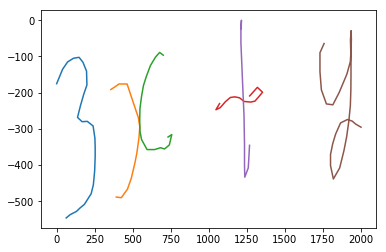

In [0]:
plot_stroke(normalized)

In [0]:
def create_input_fn(stroke_input_arr, decoder_input_arr):
  def predict_input(params):
      stroke_input = tf.expand_dims(tf.constant(stroke_input_arr, dtype=tf.int32), axis=0) 
      decoder_input = tf.expand_dims(tf.constant(decoder_input_arr, dtype=tf.int32), axis=0)

      return tf.data.Dataset.from_tensors({"input_stroke": stroke_input, "input_decoder": decoder_input})
  return predict_input

def predict_raw(stroke, decoder_input):
  return next(tpu_estimator.predict(input_fn=create_input_fn(stroke, decoder_input)))['logits']

def predict(stroke, decoder_input):
  logits = predict_raw(stroke, decoder_input)
  return [logits[i, :].argmax() for i in range(MAX_TOKEN_LEN)]

In [0]:
predict(normalized,  np.array([BEGIN_OF_SEQ, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

[37, 29, 34, 34, 34, 34, 37, 37, 37, 114, 114, 114]

In [0]:
predict(normalized,  np.array([BEGIN_OF_SEQ, 37, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

[37, 29, 34, 34, 34, 34, 34, 34, 114, 114, 114, 114]

In [0]:
predict(normalized,  np.array([BEGIN_OF_SEQ, 37, 29, 29, 29, 114, 0, 0, 0, 0, 0, 0]))

[37, 29, 34, 34, 34, 0, 0, 0, 0, 0, 0, 0]

In [0]:
predict(normalized,  np.array([BEGIN_OF_SEQ, 37, 29, 34, 29, 114, 0, 0, 0, 0, 0, 0]))

[37, 29, 34, 109, 114, 0, 0, 0, 0, 0, 0, 0]

In [0]:
predict(normalized,  np.array([BEGIN_OF_SEQ, 37, 29, 34, 109, 0, 0, 0, 0, 0, 0, 0]))

[37, 29, 34, 109, 114, 114, 114, 114, 114, 114, 114, 114]

In [0]:
predict(normalized,  np.array([BEGIN_OF_SEQ, 91, 80, 85, 85, 0, 0, 0, 0, 0, 0, 0]))

[91, 80, 85, 68, 31, 65, 65, 11, 0, 0, 0, 0]

In [0]:
predict(normalized,  np.array([BEGIN_OF_SEQ, 37, 29, 34, 109, 0, 0, 0, 0, 0, 0, 0]))

[37, 29, 34, 109, 114, 34, 75, 75, 75, 75, 75, 75]

In [0]:
predict(normalized,  np.array([BEGIN_OF_SEQ, 37, 29, 34, 0, 0, 0, 0, 0, 0, 0, 0]))

[37, 29, 34, 49, 42, 42, 0, 42, 0, 0, 0, 0]

In [0]:
predict(normalized,  np.array([BEGIN_OF_SEQ, 49, 29, 34, 0, 0, 0, 0, 0, 0, 0, 0]))

[49, 34, 34, 49, 0, 0, 0, 0, 0, 0, 0, 0]

In [0]:
predict(normalized,  np.array([BEGIN_OF_SEQ, 65, 49, 34, 49, 114, 0, 0, 0, 0, 0, 0]))

[65, 49, 34, 49, 114, 0, 0, 0, 0, 0, 0, 0]

### TensorBoard

In [34]:
!git clone https://github.com/mixuala/colab_utils

Cloning into 'colab_utils'...
remote: Enumerating objects: 243, done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 243
Receiving objects: 100% (243/243), 65.93 KiB | 3.00 MiB/s, done.
Resolving deltas: 100% (97/97), done.


In [0]:
kill_tensorboard()

In [35]:
import os
import colab_utils.tboard

ROOT = %pwd
colab_utils.tboard.launch_tensorboard(bin_dir=ROOT, log_dir=MODEL_DIR)
print(MODEL_DIR)

calling wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip ...
calling unzip ngrok-stable-linux-amd64.zip ...
ngrok installed. path=/content/ngrok
status: tensorboard=False, ngrok=False
tensorboard url= http://23aa31bb.ngrok.io
gs://karino2-tegashiki/models/transformer_pat3


In [0]:
import re

def find_one_command(res_arr, word):
  return list(filter(lambda arr: arr[4] == word, res_arr))[0]

def kill_tensorboard():
  ps_res = !ps
  res_arr = [re.split(r' +', one) for one in ps_res[1:]]
  # pid_ngrok = find_one_command(res_arr, "ngrok")[1]
  pid_tb = find_one_command(res_arr, "tensorboard")[1]
  # !kill {pid_ngrok}
  !kill {pid_tb}

In [0]:
# kill_tensorboard()

In [0]:
!ps

    PID TTY          TIME CMD
      1 ?        00:00:00 run.sh
     11 ?        00:00:12 node
     27 ?        00:00:28 jupyter-noteboo
    116 ?        00:00:01 tail
    190 ?        00:10:11 tensorboard
    192 ?        00:01:07 ngrok
   6517 ?        00:00:04 python3
   6553 ?        00:00:00 python3
   6563 ?        00:00:00 ps


# Model Export

Currently, just use the same limitation of input shape for training time to confirm conversion, etc.

In [0]:
def get_if_necessary(fname):
  if os.path.exists(fname):
    return
  !gsutil cp gs://karino2-tegashiki/dataset/{fname} {fname}

def get_and_load(fname):
  get_if_necessary(fname)
  with gzip.open(fname,'rb') as f:
    return pickle.load(f)  
  
def send_file(fname):
  !gsutil cp {fname} gs://karino2-tegashiki/dataset/
    
def dump_and_send(obj, fname):
  with gzip.open(fname,'wb') as f:
    pickle.dump(obj, f)
  send_file(fname)


In [0]:
tf.logging.set_verbosity(tf.logging.WARN)

In [39]:
MAX_STROKE_NUM*MAX_ONE_STROKE_LEN*INPUT_TYPE_DIM

4050

In [40]:
MAX_STROKE_NUM,MAX_ONE_STROKE_LEN,INPUT_TYPE_DIM

(27, 50, 3)

In [0]:
def create_serving_input():
  stroke_input_t = tf.placeholder(tf.int32, shape=[1, MAX_STROKE_NUM, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM], name='stroke_input')
  decoder_input_t = tf.placeholder(tf.int32, shape=[1, MAX_TOKEN_LEN], name='input_decoder')

  input_fn_recv = tf.estimator.export.build_raw_serving_input_receiver_fn({
      "input_stroke": stroke_input_t,
      "input_decoder": decoder_input_t
  })
  return input_fn_recv

In [0]:
# EXPORT_DIR="gs://karino2-tegashiki/models/exports/export_expgen_rnn_small_dropout05_fixshape"
# EXPORT_DIR="gs://karino2-tegashiki/models/exports/export_expgen_convencdec_posfc"
# EXPORT_DIR="gs://karino2-tegashiki/models/exports/expgen_convencdec_myembed"
# EXPORT_DIR="gs://karino2-tegashiki/models/exports/expgen_convencdec_myembed2"
# EXPORT_DIR="gs://karino2-tegashiki/models/exports/expgen_convencdec_myembed_small"
# EXPORT_DIR="gs://karino2-tegashiki/models/exports/expgen_convencdec_fixfutureleak"
# EXPORT_DIR="gs://karino2-tegashiki/models/exports/expgen_convencdec_enc256x13dec128x5"
# EXPORT_DIR="gs://karino2-tegashiki/models/exports/expgen_plain_dechidden256_fefix"

# EXPORT_DIR="gs://karino2-tegashiki/models/exports/expgen_plain_encdecatten_pat2_trainopfix"
# EXPORT_DIR="gs://karino2-tegashiki/models/exports/transformer_laynorm"

EXPORT_DIR="gs://karino2-tegashiki/models/exports/transformer_pat3"


In [43]:
tpu_estimator.export_savedmodel(
    export_dir_base=EXPORT_DIR,
    serving_input_receiver_fn=create_serving_input())

b'gs://karino2-tegashiki/models/exports/transformer_pat3/1567335705'

# Misc

In [0]:
import tensorflow as tf

In [0]:
import numpy as np

In [0]:
sess = tf.InteractiveSession()

In [0]:
a = tf.constant(np.arange(1, 31, dtype=np.int32),
                shape=[2, 5, 3])

In [0]:
sess.run(a)

array([[[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9],
        [10, 11, 12],
        [13, 14, 15]],

       [[16, 17, 18],
        [19, 20, 21],
        [22, 23, 24],
        [25, 26, 27],
        [28, 29, 30]]], dtype=int32)

In [0]:
b = tf.constant(np.arange(13, 25, dtype=np.int32),
                shape=[2, 2, 3])

In [0]:
sess.run(b)

array([[[13, 14, 15],
        [16, 17, 18]],

       [[19, 20, 21],
        [22, 23, 24]]], dtype=int32)

86

In [0]:
res = sess.run(tf.matmul(a, b, transpose_b=True))

In [0]:
res.shape

(2, 5, 2)

In [0]:
res

array([[[  86,  104],
        [ 212,  257],
        [ 338,  410],
        [ 464,  563],
        [ 590,  716]],

       [[1022, 1175],
        [1202, 1382],
        [1382, 1589],
        [1562, 1796],
        [1742, 2003]]], dtype=int32)

In [0]:
submask_bias = sess.run(subsequent_mask_bias(5))

In [0]:
submask_bias

array([[[[-0.e+00, -1.e+09, -1.e+09, -1.e+09, -1.e+09],
         [-0.e+00, -0.e+00, -1.e+09, -1.e+09, -1.e+09],
         [-0.e+00, -0.e+00, -0.e+00, -1.e+09, -1.e+09],
         [-0.e+00, -0.e+00, -0.e+00, -0.e+00, -1.e+09],
         [-0.e+00, -0.e+00, -0.e+00, -0.e+00, -0.e+00]]]], dtype=float32)

In [0]:
res2 = sess.run(tf.matmul(a, a, transpose_b=True))

In [0]:
res2

array([[[  14,   32,   50,   68,   86],
        [  32,   77,  122,  167,  212],
        [  50,  122,  194,  266,  338],
        [  68,  167,  266,  365,  464],
        [  86,  212,  338,  464,  590]],

       [[ 869, 1022, 1175, 1328, 1481],
        [1022, 1202, 1382, 1562, 1742],
        [1175, 1382, 1589, 1796, 2003],
        [1328, 1562, 1796, 2030, 2264],
        [1481, 1742, 2003, 2264, 2525]]], dtype=int32)

In [0]:
sess.run(tf.nn.softmax(res2+submask_bias))

array([[[[1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
          0.00000000e+000, 0.00000000e+000],
         [2.86251858e-020, 1.00000000e+000, 0.00000000e+000,
          0.00000000e+000, 0.00000000e+000],
         [2.89464031e-063, 5.38018616e-032, 1.00000000e+000,
          0.00000000e+000, 0.00000000e+000],
         [1.03404366e-129, 1.02256891e-086, 1.01122149e-043,
          1.00000000e+000, 0.00000000e+000],
         [1.30491169e-219, 6.86571609e-165, 3.61235614e-110,
          1.90061994e-055, 1.00000000e+000]],

        [[1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
          0.00000000e+000, 0.00000000e+000],
         [6.71418429e-079, 1.00000000e+000, 0.00000000e+000,
          0.00000000e+000, 0.00000000e+000],
         [1.59251852e-180, 1.26195028e-090, 1.00000000e+000,
          0.00000000e+000, 0.00000000e+000],
         [1.33436212e-305, 5.62577643e-204, 2.37187193e-102,
          1.00000000e+000, 0.00000000e+000],
         [0.00000000e+000, 0.00000000e+000, 

In [0]:
res2+submask_bias

array([[[[ 1.40000000e+01, -9.99999968e+08, -9.99999950e+08,
          -9.99999932e+08, -9.99999914e+08],
         [ 3.20000000e+01,  7.70000000e+01, -9.99999878e+08,
          -9.99999833e+08, -9.99999788e+08],
         [ 5.00000000e+01,  1.22000000e+02,  1.94000000e+02,
          -9.99999734e+08, -9.99999662e+08],
         [ 6.80000000e+01,  1.67000000e+02,  2.66000000e+02,
           3.65000000e+02, -9.99999536e+08],
         [ 8.60000000e+01,  2.12000000e+02,  3.38000000e+02,
           4.64000000e+02,  5.90000000e+02]],

        [[ 8.69000000e+02, -9.99998978e+08, -9.99998825e+08,
          -9.99998672e+08, -9.99998519e+08],
         [ 1.02200000e+03,  1.20200000e+03, -9.99998618e+08,
          -9.99998438e+08, -9.99998258e+08],
         [ 1.17500000e+03,  1.38200000e+03,  1.58900000e+03,
          -9.99998204e+08, -9.99997997e+08],
         [ 1.32800000e+03,  1.56200000e+03,  1.79600000e+03,
           2.03000000e+03, -9.99997736e+08],
         [ 1.48100000e+03,  1.74200000e+03, 

In [0]:
sess.run(tf.linalg.band_part(tf.ones([7, 7], dtype=tf.float32),
                                     -1, 0))

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1.]], dtype=float32)

In [0]:
sess.run(tf.reshape(tf.linalg.band_part(tf.ones([7, 7], dtype=tf.float32),
                                     -1, 0), [1, 1, 7, 7]))

array([[[[1., 0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 1., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1., 1., 1.]]]], dtype=float32)

In [0]:
import math

In [0]:
# 1+2*(k-1)*(2^n-1) #> 500
# 1+2*7*(2^n-1) > 500
# 2^n-1 > 499/14
# 2^n > 1+499/14
math.log2(1+ (499/14.0))

In [0]:
# 1+2*(k-1)*(2^n-1) #> 500
# 1+2*7*(2^n-1) > 500
# 2^n-1 > 499/14
# 2^n > 1+499/14
math.log2(1+ (499/14.0))

 https://arxiv.org/abs/1803.01271

try to cover 500 len. and attention will handle larger case.
As paper noted, best kernel size depend on task.
I start from k=8 because our task is somewhat similar to P-MNIST, and k=8 is best for that task.

In [0]:
# TCN residual block in paper
# filter_size must be the same as out_channels?

# filter_size=32
def TCNResBlock(input, layer_depth, filter_size=3, kernel_size=8, dropout_rate=0.2):
  d = 2**layer_depth
  x = Conv1D(filter_size, kernel_size, activation='relu', dilation_rate=d, padding='causal', kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(input)
  
  # https://github.com/ychfan/tf_estimator_barebone/blob/master/common/layers.py
  # weight norm implementation. But I use layer_norm for first trial.
  x = tf.contrib.layers.layer_norm(x)
  x = SpatialDropout1D(dropout_rate)(x)

  x = Conv1D(filter_size, kernel_size, activation='relu', dilation_rate=d, padding='causal', kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(x)
  x = tf.contrib.layers.layer_norm(x)
  x = SpatialDropout1D(dropout_rate)(x)
  return tf.nn.relu(x + input)

def TCN(input, depth=8):
  x = input
  for i in range(depth):
    x = TCNResBlock(x, i)
  return x


In [0]:
def encoder_TCN(input_from_encoder_t):
  conved = TCN(input_from_encoder_t)

  state_for_dec = Dense(GRU_HIDDEN, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(conved[:, -1, :])
  
  pooled = AveragePooling1D(10)(conved)
  return pooled, state_for_dec

def encoder_CNNRNN(input_from_encoder_t, dropout_rate=DROPOUT_RATE):
  conved = Conv1D(32, 7, activation='relu', kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(input_from_encoder_t)
  pooled = AveragePooling1D(10)(conved)

  ht_enc, state_enc = GRU(GRU_HIDDEN, return_sequences=True,return_state=True, dropout=dropout_rate, recurrent_dropout=dropout_rate, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), recurrent_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(pooled)
  return ht_enc, state_enc

In [0]:
def create_model_nostroke(input_stroke_t, decoder_input_t, maxtklen=MAX_TOKEN_LEN):
  dec_input_embedded = Embedding(VOCAB_SIZE, EMBEDDING_SIZE, input_length=maxtklen)(decoder_input_t)
  # (batch, 98, 256)


  # (sample, timestamps, htdim)
  ht_last = GRU(GRU_HIDDEN, return_sequences=True, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), recurrent_regularizer=regularizers.l2(L2_REGULARIZATION_RATE))(dec_input_embedded)

  # (Sample, 98, 112)
  logit = TimeDistributed(Dense(VOCAB_SIZE, kernel_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), bias_regularizer=regularizers.l2(L2_REGULARIZATION_RATE), activity_regularizer=regularizers.l2(L2_REGULARIZATION_RATE)))(ht_last)

  return logit
